In [43]:
# Packages
import numpy as np
import os
import sys
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["ITK_LOG_LEVEL"] = "0"  # Suppress all log messages

# suppress all the warnings
class NullWriter:
    def write(self, *args, **kwargs):
        pass

    def flush(self):
        pass

sys.stderr = NullWriter()

import cv2

import torch
from torchvision import models
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset
import torchvision.transforms as transforms
import torch.optim as optim


from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from scipy.spatial.distance import directed_hausdorff

import SimpleITK as sitk

# import itk

# Set the logging level to suppress warnings
# itk.GlobalDefaultLogging().SetLevel(itk.logging.LogLevel.ERROR)  # This will suppress warnings and info messages



# Results:

## Problem 1:
UNet->
Dice Coefficient: 0.9741  
Hausdorff:  

## Problem 2:  
TransUNet->
Dice Coefficient: 0.9742  
Hausdorff:  
  
## Problem 3:
UNet->  
Dice Coefficient: 0.7436  
Hausdorff:
  
TransUNet->  
Dice Coefficient: 0.6897  
Hausdorff:  

ResUNet->  
Dice Coefficient: 0.8227  
Hausdorff: 


# Results Discussion:
UNet and TransUNet are both very effective in properly segmenting out the lung region from the rest of the image. Since both the lung and non-lung regions are relatively large, the dice coefficient is a very telling metric. Had one of the regions been very small, then a large dice coefficient can be reached with poor segmentation accuracy due to the sheer size of one of the regions. However, looking at the segmentation images, we can see that this is not the case. While the boundaries are not exact, and small regions of "lung" can sometimes be classified in areas where there is none, the general shape is usually quite good, and UNet can have some difficulty in regions outside the lung that have similar marks as lung, especially when categorizing a scan of someone with a sickness. TransUNet would theoretically get better results with the inclusion of a transformer encoder that could help with positional encoding and attention, but we do not see that here. The results are relatively similar to the regular UNet. Since the UNet performed very well anyway in the binary segmentation perhaps there was not much improvement to be had.  

For problem 3, we moved to multiclass segmentation of 2D images. For the last week or two, hipergator has been having trouble and the jupyter notebook server would constantly lose connection, go slowly, crash/freeze, and not save properly losing saved code or data. To keep training quick, and because the data on the website did not describe very well what each file fully was, I only used the first 3 slices from frame01 in each folder. When attempting to use the full frame01 for each training patient, training would take forever and often freeze up. I increased the number of training iterations greatly to help allow further learning; however, the low number of training points means that the models often overfit and did not fit test very well. This can be seen in the much lower dice-coefficients in the multiclass images. UNet and ResNet performed better since they generalized ok with the small amount of data. This can be seen both in the higher dice-coefficients and in some of the segmentation results that often match ok to the masks. The TransUNet's transformer will overfit too much to the train data due to the small sample size, so the average dice-coefficient is very low and the segmentation results often look nothing like the masks.

In [13]:
# Classes

class downNet1(nn.Module):
    def __init__(self):
        super(downNet1, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)

        # Activation Function
        self.act1 = nn.ReLU()

        # Second 2D convolutional layer, taking in the 64 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)

        # Activation Function
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output

    
class downNet2(nn.Module):
    def __init__(self):
        super(downNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(64, 128, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(128, 128, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output
        
        
class downNet3(nn.Module):
    def __init__(self):
        super(downNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(128, 256, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(256, 256, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output
        
        
class downNet4(nn.Module):
    def __init__(self):
        super(downNet4, self).__init__()
        
        self.conv1 = nn.Conv2d(256, 512, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(512, 512, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output
        
class upNet1(nn.Module):
    def __init__(self):
        super(upNet1, self).__init__()

        self.conv1 = nn.Conv2d(1024, 512, 3, 1, padding=1)

        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(512, 512, 3, 1, padding=1)

        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(512, 256, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output

    
class upNet2(nn.Module):
    def __init__(self):
        super(upNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(512, 256, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(256, 256, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(256, 128, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
        
class upNet3(nn.Module):
    def __init__(self):
        super(upNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(256, 128, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(128, 128, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(128, 64, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
        
class upNet4(nn.Module):
    def __init__(self):
        super(upNet4, self).__init__()
        
        self.conv1 = nn.Conv2d(128, 64, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        # 2 classes, so final output should be 2
        self.conv3 = nn.Conv2d(64, 1, 1, 1) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)
        output = x
        return output
        
        
class bottleNeck(nn.Module):
    def __init__(self):
        super(bottleNeck, self).__init__()
        
        self.conv1 = nn.Conv2d(512, 1024, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(1024, 1024, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(1024, 512, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
     
class pool(nn.Module):
    def __init__(self):
        super(pool, self).__init__()

        self.pooling = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pooling(x)
        output = x
        return output
        
       
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder (Downsampling)
        self.down1 = downNet1()
        self.pool1 = pool()
        
        self.down2 = downNet2()
        self.pool2 = pool()
        
        self.down3 = downNet3()
        self.pool3 = pool()
        
        self.down4 = downNet4()
        self.pool4 = pool()
        
        # Bottleneck
        self.bottleneck = bottleNeck()
        
        # Decoder (Upsampling)
        self.up1 = upNet1()
        self.up2 = upNet2()
        self.up3 = upNet3()
        self.up4 = upNet4()
        
    def copy_and_crop(self, upsampled, skip):
        # Crop the skip connection to match the upsampled dimensions
        _, _, H, W = upsampled.size()
        skip = skip[:, :, :H, :W]  # Crop the skip connection
        return torch.cat((upsampled, skip), dim=1) 
        
    def forward(self, x):
        # Downsampling path
        
        enc1 = self.down1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.down2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        enc3 = self.down3(enc2_pool)
        enc3_pool = self.pool3(enc3)
        
        enc4 = self.down4(enc3_pool)
        enc4_pool = self.pool4(enc4)
        
        # Bottleneck
        bottleneck_out = self.bottleneck(enc4_pool)
        
        # Upsampling path
        copy1 = self.copy_and_crop(bottleneck_out, enc4)
        dec1 = self.up1(copy1)
         
        copy2 = self.copy_and_crop(dec1, enc3)
        dec2 = self.up2(copy2)
        
        copy3 = self.copy_and_crop(dec2, enc2)  # Skip connection
        dec3 = self.up3(copy3)
        
        copy4 = self.copy_and_crop(dec3, enc1)  # Skip connection
        dec4 = self.up4(copy4)
        
        
        return dec4

    
    


# Transformer
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x shape: (B, C, H, W) -> (H*W, B, C)
        B, C, H, W = x.size()
        x = x.permute(0, 2, 3, 1).reshape(-1, B, C)
        
        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        x = x.view(H, W, B, C).permute(2, 3, 0, 1)  # (B, C, H, W)
        return x
    
    
class TransUNet(nn.Module):
    def __init__(self):
        super(TransUNet, self).__init__()

        # Encoder (Downsampling)
        self.down1 = downNet1()
        self.pool1 = pool()
        
        self.down2 = downNet2()
        self.pool2 = pool()
        
        self.down3 = downNet3()
        self.pool3 = pool()
        
        self.down4 = downNet4()
        self.pool4 = pool()
        
        # Bottleneck
        self.bottleneck = bottleNeck()

        # Transformer Encoder
        self.transformer = TransformerEncoder(embed_dim=512, num_heads=8, num_layers=4)

        # Decoder (Upsampling)
        self.up1 = upNet1()
        self.up2 = upNet2()
        self.up3 = upNet3()
        self.up4 = upNet4()

    def copy_and_crop(self, upsampled, skip):
        # Crop the skip connection to match the upsampled dimensions
        _, _, H, W = upsampled.size()
        skip = skip[:, :, :H, :W]  # Crop the skip connection
        return torch.cat((upsampled, skip), dim=1) 
        
    def forward(self, x):
        # Downsampling path
        
        enc1 = self.down1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.down2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        enc3 = self.down3(enc2_pool)
        enc3_pool = self.pool3(enc3)
        
        enc4 = self.down4(enc3_pool)
        enc4_pool = self.pool4(enc4)
        
        # Bottleneck
        bottleneck_out = self.bottleneck(enc4_pool)

        # Apply Transformer
        transformer_out = self.transformer(bottleneck_out)

        # Upsampling path
        copy1 = self.copy_and_crop(transformer_out, enc4)
        dec1 = self.up1(copy1)
         
        copy2 = self.copy_and_crop(dec1, enc3)
        dec2 = self.up2(copy2)
        
        copy3 = self.copy_and_crop(dec2, enc2)  # Skip connection
        dec3 = self.up3(copy3)
        
        copy4 = self.copy_and_crop(dec3, enc1)  # Skip connection
        dec4 = self.up4(copy4)
        
        return dec4

 ###### Measures #########   
    
# Dice Coefficient
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice


def hausdorff_distance(mask1, mask2):
    # Ensure the masks are binary (0s and 1s)
    mask1 = (mask1 > 0).float()
    mask2 = (mask2 > 0).float()

    # Get coordinates of the white pixels (1s)
    coords1 = torch.nonzero(mask1, as_tuple=False).float()
    coords2 = torch.nonzero(mask2, as_tuple=False).float()

    if coords1.numel() == 0 or coords2.numel() == 0:
        # If either mask has no white pixels, return infinity
        return float('inf')

    def directed_hausdorff(coords_from, coords_to):
        max_distance = 0.0
        for point_from in coords_from:
            # Calculate distances from this point to all points in coords_to
            distances = torch.norm(coords_to - point_from, dim=1)  # L2 distance
            min_distance = distances.min()
            max_distance = max(max_distance, min_distance.item())
        return max_distance

    # Calculate the directed Hausdorff distances
    d1 = directed_hausdorff(coords1, coords2)  # Distance from mask1 to mask2
    d2 = directed_hausdorff(coords2, coords1)  # Distance from mask2 to mask1

    # The Hausdorff distance is the maximum of these two distances
    hausdorff_dist = max(d1, d2)

    return hausdorff_dist



my_nn = TransUNet()
# print(my_nn)

In [3]:
# Run a test
random_data = torch.rand((1, 1, 224, 224))

result = my_nn(random_data)
print(result[:,0,:,:])

tensor([[[-0.1140, -0.1242, -0.1177,  ..., -0.1234, -0.1227, -0.1235],
         [-0.1140, -0.1231, -0.1244,  ..., -0.1291, -0.1252, -0.1245],
         [-0.1193, -0.1267, -0.1289,  ..., -0.1350, -0.1310, -0.1236],
         ...,
         [-0.1174, -0.1305, -0.1254,  ..., -0.1244, -0.1278, -0.1235],
         [-0.1189, -0.1246, -0.1255,  ..., -0.1249, -0.1291, -0.1251],
         [-0.1196, -0.1258, -0.1279,  ..., -0.1261, -0.1263, -0.1249]]],
       grad_fn=<SliceBackward0>)


In [4]:
# Classes to load in data

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load the image
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        image = cv2.imread(img_path)  # Load image
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Load the corresponding mask
        mask_path = os.path.join(self.masks_dir, self.image_filenames[idx])  # Assuming masks have the same filename
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure mask is of type long for segmentation
        mask = mask.long()  

        return image, mask


class MultiDataset(Dataset):
    def __init__(self, image_dirs, mask_dirs, transform=None):
        self.image_dirs = image_dirs
        self.mask_dirs = mask_dirs
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []
        
        # Collect image and mask paths
        for img_dir, mask_dir in zip(image_dirs, mask_dirs):
            img_files = os.listdir(img_dir)
            for img_file in img_files:
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, img_file)  # Assume the same naming
                if os.path.exists(mask_path):  # Ensure mask exists
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Load images and masks
        image = cv2.imread(img_path)  # Load image
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Ensure mask is of type long for segmentation
        # mask = mask.long()

        return image, mask





In [5]:
# Load the data

dataPath = [
    'ImagesAndMasks/AllCovid/Covid',
    'ImagesAndMasks/AllNormal/Normal',
    'ImagesAndMasks/AllOpacity/Lung_Opacity',
    'ImagesAndMasks/AllPneumonia/Viral_Pneumonia'   
]

maskPath = [
    'ImagesAndMasks/AllCovid/COVIDmasks',
    'ImagesAndMasks/AllNormal/Normalmasks',
    'ImagesAndMasks/AllOpacity/Lung_Opacitymasks',
    'ImagesAndMasks/AllPneumonia/Viral_Pneumoniamasks'
]


# Define your transformations
transform = transforms.Compose([
    transforms.ToPILImage(),               # Convert to PIL Image first
    transforms.Resize((224, 224)),         # Resize to 224x224
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),                  # Convert image to tensor
])


#
dataset = MultiDataset(dataPath, maskPath, transform=transform)

# Split into train, test, val
trainRatio = 0.75
valRatio = 0.1
testRatio = 1 - trainRatio - valRatio

# Calculate the sizes of each split
train_size = int(trainRatio * len(dataset))
val_size = int(valRatio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# # Create the DataLoader
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# print(dataloader.mask)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
# Regular U-Net
model = UNet()

model.to(device) 

criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        images = images.float()  # Convert to FloatTensor
        masks = masks.float()     # Convert to FloatTensor
        # print(f"Images type: {images.dtype}, shape: {images.shape}")
        # print(f"Masks type: {masks.dtype}, shape: {masks.shape}")
        # print(images)
        
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # print(f"Output shape: {outputs.shape}")

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    
    # Set the model to evaluation mode
    model.eval()
    
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            masks = masks.float()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
    
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    

print('Training complete.')

Epoch [1/10], Loss: 0.2371
Validation Loss: 0.1793
Epoch [2/10], Loss: 0.0720
Validation Loss: 0.0687
Epoch [3/10], Loss: 0.0514
Validation Loss: 0.0447
Epoch [4/10], Loss: 0.0398
Validation Loss: 0.0451
Epoch [5/10], Loss: 0.0339
Validation Loss: 0.0318
Epoch [6/10], Loss: 0.0299
Validation Loss: 0.0296
Epoch [7/10], Loss: 0.0268
Validation Loss: 0.0320
Epoch [8/10], Loss: 0.0250
Validation Loss: 0.0262
Epoch [9/10], Loss: 0.0234
Validation Loss: 0.0260
Epoch [10/10], Loss: 0.0218
Validation Loss: 0.0302
Training complete.


In [15]:
# Run test data and apply to measures

model.eval()

dice = []
# haus = []
test_loss = 0

with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            masks = masks.float()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            # turn logit to probability
            probs = torch.sigmoid(outputs)
            
            # create predictions
            preds = (probs > 0.5).float()
            preds = preds.to(device)
            
            batch_dice =dice_coefficient(preds, masks)
            
            # batch_haus = hausdorff_distance(preds, masks)
            
                        
            dice.append(batch_dice)
            haus.append(batch_haus)
 
# Stack tensors into one
dice = torch.stack(dice)
# haus = torch.stack(haus)

# Calculate average Dice score
average_dice = dice.mean().item()  # Get the mean and convert to Python float

# Calculate average Hausdorff Distance
# average_haus = haus.mean().item()
            
print(f'Average Dice Score is: {average_dice:.4f}')
# print('Average Hausdorff Distance is: ', average_haus)
print(f'Test Loss: {test_loss/len(test_loader):.4f}')


Average Dice Score is: 0.9741
Test Loss: 0.0302


In [ ]:
# probs = torch.sigmoid(outputs)
            
# # create predictions
# preds = (probs > 0.5).float()

# preds_cpu = preds.cpu()
masks_cpu = masks.cpu

# Convert to NumPy array
preds_numpy = preds_cpu.numpy()
masks_numpy = masks_cpu.numpy()

plt.imshow(preds_numpy[1,0,:,:], cmap='gray')
plt.imshow(masks_numpy[1,0,:,:], cmap='gray')

# Part 2 TransUNet

In [16]:
# TransU-Net
model = TransUNet()

model.to(device) 

criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        images = images.float()  # Convert to FloatTensor
        masks = masks.float()     # Convert to FloatTensor
        # print(f"Images type: {images.dtype}, shape: {images.shape}")
        # print(f"Masks type: {masks.dtype}, shape: {masks.shape}")
        # print(images)
        
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # print(f"Output shape: {outputs.shape}")

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    
    # Set the model to evaluation mode
    model.eval()
    
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            masks = masks.float()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
    
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    

print('Training complete.')

Epoch [1/10], Loss: 0.2756
Validation Loss: 0.1279
Epoch [2/10], Loss: 0.0919
Validation Loss: 0.1026
Epoch [3/10], Loss: 0.0666
Validation Loss: 0.0643
Epoch [4/10], Loss: 0.0542
Validation Loss: 0.0529
Epoch [5/10], Loss: 0.0453
Validation Loss: 0.0431
Epoch [6/10], Loss: 0.0400
Validation Loss: 0.0393
Epoch [7/10], Loss: 0.0352
Validation Loss: 0.0380
Epoch [8/10], Loss: 0.0325
Validation Loss: 0.0343
Epoch [9/10], Loss: 0.0303
Validation Loss: 0.0331
Epoch [10/10], Loss: 0.0286
Validation Loss: 0.0299
Training complete.


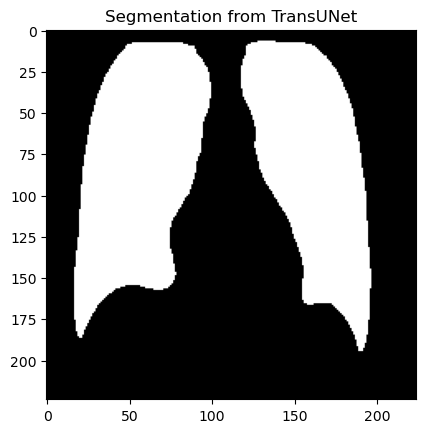

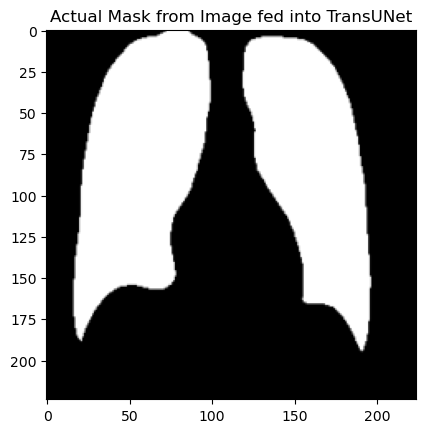

In [23]:
# turn logit to probability
probs = torch.sigmoid(outputs)
            
# create predictions
preds = (probs > 0.5).float()

preds_cpu = preds.cpu()
# masks_cpu= masks.cpu()

# Convert to NumPy array
preds_numpy = preds_cpu.numpy()
# masks_cpu = masks.numpy()

plt.figure()
plt.imshow(preds_numpy[1,0,:,:], cmap='gray')
plt.title('Segmentation from TransUNet')
plt.savefig('binaryTransUNet_prediction.png')

plt.figure()
plt.imshow(masks[1,0,:,:], cmap='gray')
plt.title('Actual Mask from Image fed into TransUNet')
plt.savefig('binaryTransUNet_mask.png')

In [25]:
# Run test data and apply to measures

model.eval()

dice = []
# haus = []
test_loss = 0

with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            masks = masks.float()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            # turn logit to probability
            probs = torch.sigmoid(outputs)
            
            # create predictions
            preds = (probs > 0.5).float()
            
            batch_dice =dice_coefficient(preds, masks)
                        
            dice.append(batch_dice)
 
# Stack tensors into one
dice = torch.stack(dice)  

# Calculate average Dice score
average_dice = dice.mean().item()  # Get the mean and convert to Python float
            
print(f'Average Dice Score is: {average_dice:.4f}')
print(f'Validation Loss: {test_loss/len(test_loader):.4f}')


Average Dice Score is: 0.9742
Validation Loss: 0.0298


# Part 3
Now we have 4 classes to distinguish

In [41]:
# Classes

class downNet1(nn.Module):
    def __init__(self):
        super(downNet1, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)

        # Activation Function
        self.act1 = nn.ReLU()

        # Second 2D convolutional layer, taking in the 64 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)

        # Activation Function
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output

    
class downNet2(nn.Module):
    def __init__(self):
        super(downNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(64, 128, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(128, 128, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output
        
        
class downNet3(nn.Module):
    def __init__(self):
        super(downNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(128, 256, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(256, 256, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output
        
        
class downNet4(nn.Module):
    def __init__(self):
        super(downNet4, self).__init__()
        
        self.conv1 = nn.Conv2d(256, 512, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(512, 512, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        output = x
        return output
        
class upNet1(nn.Module):
    def __init__(self):
        super(upNet1, self).__init__()

        self.conv1 = nn.Conv2d(1024, 512, 3, 1, padding=1)

        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(512, 512, 3, 1, padding=1)

        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(512, 256, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output

    
class upNet2(nn.Module):
    def __init__(self):
        super(upNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(512, 256, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(256, 256, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(256, 128, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
        
class upNet3(nn.Module):
    def __init__(self):
        super(upNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(256, 128, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(128, 128, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(128, 64, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
        
class upNet4(nn.Module):
    def __init__(self):
        super(upNet4, self).__init__()
        
        self.conv1 = nn.Conv2d(128, 64, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        # 4 classes, so final output should be 4
        self.conv3 = nn.Conv2d(64, 4, 1, 1) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)
        output = x
        return output
        
        
class bottleNeck(nn.Module):
    def __init__(self):
        super(bottleNeck, self).__init__()
        
        self.conv1 = nn.Conv2d(512, 1024, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(1024, 1024, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(1024, 512, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
     
class pool(nn.Module):
    def __init__(self):
        super(pool, self).__init__()

        self.pooling = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pooling(x)
        output = x
        return output
        
       
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder (Downsampling)
        self.down1 = downNet1()
        self.pool1 = pool()
        
        self.down2 = downNet2()
        self.pool2 = pool()
        
        self.down3 = downNet3()
        self.pool3 = pool()
        
        self.down4 = downNet4()
        self.pool4 = pool()
        
        # Bottleneck
        self.bottleneck = bottleNeck()
        
        # Decoder (Upsampling)
        self.up1 = upNet1()
        self.up2 = upNet2()
        self.up3 = upNet3()
        self.up4 = upNet4()
        
    def copy_and_crop(self, upsampled, skip):
        # Crop the skip connection to match the upsampled dimensions
        _, _, H, W = upsampled.size()
        skip = skip[:, :, :H, :W]  # Crop the skip connection
        return torch.cat((upsampled, skip), dim=1) 
        
    def forward(self, x):
        # Downsampling path
        
        enc1 = self.down1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.down2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        enc3 = self.down3(enc2_pool)
        enc3_pool = self.pool3(enc3)
        
        enc4 = self.down4(enc3_pool)
        enc4_pool = self.pool4(enc4)
        
        # Bottleneck
        bottleneck_out = self.bottleneck(enc4_pool)
        
        # Upsampling path
        copy1 = self.copy_and_crop(bottleneck_out, enc4)
        dec1 = self.up1(copy1)
         
        copy2 = self.copy_and_crop(dec1, enc3)
        dec2 = self.up2(copy2)
        
        copy3 = self.copy_and_crop(dec2, enc2)  # Skip connection
        dec3 = self.up3(copy3)
        
        copy4 = self.copy_and_crop(dec3, enc1)  # Skip connection
        dec4 = self.up4(copy4)
        
        
        return dec4

    
    


# Transformer
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x shape: (B, C, H, W) -> (H*W, B, C)
        B, C, H, W = x.size()
        x = x.permute(0, 2, 3, 1).reshape(-1, B, C)
        
        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        x = x.view(H, W, B, C).permute(2, 3, 0, 1)  # (B, C, H, W)
        return x
    
    
class TransUNet(nn.Module):
    def __init__(self):
        super(TransUNet, self).__init__()

        # Encoder (Downsampling)
        self.down1 = downNet1()
        self.pool1 = pool()
        
        self.down2 = downNet2()
        self.pool2 = pool()
        
        self.down3 = downNet3()
        self.pool3 = pool()
        
        self.down4 = downNet4()
        self.pool4 = pool()
        
        # Bottleneck
        self.bottleneck = bottleNeck()

        # Transformer Encoder
        self.transformer = TransformerEncoder(embed_dim=512, num_heads=8, num_layers=4)

        # Decoder (Upsampling)
        self.up1 = upNet1()
        self.up2 = upNet2()
        self.up3 = upNet3()
        self.up4 = upNet4()

    def copy_and_crop(self, upsampled, skip):
        # Crop the skip connection to match the upsampled dimensions
        _, _, H, W = upsampled.size()
        skip = skip[:, :, :H, :W]  # Crop the skip connection
        return torch.cat((upsampled, skip), dim=1) 
        
    def forward(self, x):
        # Downsampling path
        
        enc1 = self.down1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.down2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        enc3 = self.down3(enc2_pool)
        enc3_pool = self.pool3(enc3)
        
        enc4 = self.down4(enc3_pool)
        enc4_pool = self.pool4(enc4)
        
        # Bottleneck
        bottleneck_out = self.bottleneck(enc4_pool)

        # Apply Transformer
        transformer_out = self.transformer(bottleneck_out)

        # Upsampling path
        copy1 = self.copy_and_crop(transformer_out, enc4)
        dec1 = self.up1(copy1)
         
        copy2 = self.copy_and_crop(dec1, enc3)
        dec2 = self.up2(copy2)
        
        copy3 = self.copy_and_crop(dec2, enc2)  # Skip connection
        dec3 = self.up3(copy3)
        
        copy4 = self.copy_and_crop(dec3, enc1)  # Skip connection
        dec4 = self.up4(copy4)
        
        return dec4

 ###### Measures #########   
    
# Dice Coefficient
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def multi_class_dice_coefficient(preds, targets, num_classes, smooth=1e-6):
    dice_scores = []

    for cls in range(num_classes):
        # Create binary masks for the current class
        preds_cls = (preds == cls).float()
        targets_cls = (targets == cls).float()

        # Calculate intersection and union
        intersection = (preds_cls * targets_cls).sum()
        dice = (2. * intersection + smooth) / (preds_cls.sum() + targets_cls.sum() + smooth)

        dice_scores.append(dice)

    # Return the average Dice score across all classes
    return torch.mean(torch.tensor(dice_scores))



# def hausdorff_distance(mask1, mask2):
#     # Get coordinates of the white pixels (1s)
#     coords1 = np.argwhere(mask1 == 1)
#     coords2 = np.argwhere(mask2 == 1)

#     if coords1.size == 0 or coords2.size == 0:
#         # If either mask has no white pixels, return infinity
#         return float('inf')

#     # Calculate the directed Hausdorff distances
#     d1 = directed_hausdorff(coords1, coords2)[0]  # Distance from mask1 to mask2
#     d2 = directed_hausdorff(coords2, coords1)[0]  # Distance from mask2 to mask1

#     # The Hausdorff distance is the maximum of these two distances
#     hausdorff_dist = max(d1, d2)

#     return hausdorff_dist

# my_nn = TransUNet()
# print(my_nn)


# ResUNet

class downResNet1(nn.Module):
    def __init__(self):
        super(downResNet1, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)

        # Activation Function
        self.act1 = nn.ReLU()

        # Second 2D convolutional layer, taking in the 64 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)

        # Activation Function
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        y = x
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        output = x
        return output

    
class downResNet2(nn.Module):
    def __init__(self):
        super(downResNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(64, 128, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(128, 128, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        output = x
        return output
        
        
class downResNet3(nn.Module):
    def __init__(self):
        super(downResNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(128, 256, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(256, 256, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        output = x
        return output
        
        
class downResNet4(nn.Module):
    def __init__(self):
        super(downResNet4, self).__init__()
        
        self.conv1 = nn.Conv2d(256, 512, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(512, 512, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        output = x
        return output
        
class upResNet1(nn.Module):
    def __init__(self):
        super(upResNet1, self).__init__()

        self.conv1 = nn.Conv2d(1024, 512, 3, 1, padding=1)

        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(512, 512, 3, 1, padding=1)

        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(512, 256, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output

    
class upResNet2(nn.Module):
    def __init__(self):
        super(upResNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(512, 256, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(256, 256, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(256, 128, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
        
class upResNet3(nn.Module):
    def __init__(self):
        super(upResNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(256, 128, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(128, 128, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(128, 64, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
        
class upResNet4(nn.Module):
    def __init__(self):
        super(upResNet4, self).__init__()
        
        self.conv1 = nn.Conv2d(128, 64, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        # 4 classes, so final output should be 4
        self.conv3 = nn.Conv2d(64, 4, 1, 1) 
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        x = self.conv3(x)
        output = x
        return output
        
        
class ResbottleNeck(nn.Module):
    def __init__(self):
        super(ResbottleNeck, self).__init__()
        
        self.conv1 = nn.Conv2d(512, 1024, 3, 1, padding=1)
        
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(1024, 1024, 3, 1, padding=1)
        
        self.act2 = nn.ReLU()
        
        self.upSamp = nn.ConvTranspose2d(1024, 512, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        y = x
        x = self.act1(x)
        x = self.conv2(x)
        x = x + y
        x = self.act2(x)
        x = self.upSamp(x)
        output = x
        return output
        
     
# class pool(nn.Module):
#     def __init__(self):
#         super(pool, self).__init__()

#         self.pooling = nn.MaxPool2d(2, 2)
        
#     def forward(self, x):
#         x = self.pooling(x)
#         output = x
#         return output
        
       
class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()
        
        # Encoder (Downsampling)
        self.down1 = downResNet1()
        self.pool1 = pool()
        
        self.down2 = downResNet2()
        self.pool2 = pool()
        
        self.down3 = downResNet3()
        self.pool3 = pool()
        
        self.down4 = downResNet4()
        self.pool4 = pool()
        
        # Bottleneck
        self.bottleneck = ResbottleNeck()
        
        # Decoder (Upsampling)
        self.up1 = upResNet1()
        self.up2 = upResNet2()
        self.up3 = upResNet3()
        self.up4 = upResNet4()
        
    def copy_and_crop(self, upsampled, skip):
        # Crop the skip connection to match the upsampled dimensions
        _, _, H, W = upsampled.size()
        skip = skip[:, :, :H, :W]  # Crop the skip connection
        return torch.cat((upsampled, skip), dim=1) 
        
    def forward(self, x):
        # Downsampling path
        
        enc1 = self.down1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.down2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        enc3 = self.down3(enc2_pool)
        enc3_pool = self.pool3(enc3)
        
        enc4 = self.down4(enc3_pool)
        enc4_pool = self.pool4(enc4)
        
        # Bottleneck
        bottleneck_out = self.bottleneck(enc4_pool)
        
        # Upsampling path
        copy1 = self.copy_and_crop(bottleneck_out, enc4)
        dec1 = self.up1(copy1)
         
        copy2 = self.copy_and_crop(dec1, enc3)
        dec2 = self.up2(copy2)
        
        copy3 = self.copy_and_crop(dec2, enc2)  # Skip connection
        dec3 = self.up3(copy3)
        
        copy4 = self.copy_and_crop(dec3, enc1)  # Skip connection
        dec4 = self.up4(copy4)
        
        
        return dec4


In [27]:
resModel = ResUNet()
print(resModel)

ResUNet(
  (down1): downResNet1(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act2): ReLU()
  )
  (pool1): pool(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): downResNet2(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act2): ReLU()
  )
  (pool2): pool(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): downResNet3(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act2): ReLU()
  )
  (pool3): pool(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [37]:
# # TransU-Net
# # model = TransUNet()

# resModel.to(device) 

# criterion = nn.BCEWithLogitsLoss()  # For binary classification
# optimizer = optim.Adam(resModel.parameters(), lr=1e-4)  # Adjust learning rate as needed

# # Training loop
# num_epochs = 10  # Set the number of epochs
# for epoch in range(num_epochs):
#     resModel.train()  # Set model to training mode
#     running_loss = 0.0

#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device)
#         images = images.float()  # Convert to FloatTensor
#         masks = masks.float()     # Convert to FloatTensor
#         # print(f"Images type: {images.dtype}, shape: {images.shape}")
#         # print(f"Masks type: {masks.dtype}, shape: {masks.shape}")
#         # print(images)
        
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = resModel(images)
#         # print(f"Output shape: {outputs.shape}")

#         # Calculate loss
#         loss = criterion(outputs, masks)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # Print epoch loss
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    
#     # Set the model to evaluation mode
#     resModel.eval()
    
#     val_loss = 0.0
    
#     with torch.no_grad():
#         for images, masks in val_loader:
#             images = images.to(device)
#             masks = masks.to(device)
#             images = images.float()  # Convert to FloatTensor
#             masks = masks.float()
            
#             # print(images.shape)
#             # print(masks.shape)

#             outputs = resModel(images)
            
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()
            
    
#     print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    

# print('Training complete.')

In [102]:
# Load in the data

# The homework and the database don't really describe what the actual frames mean, so I will just load in frame 1 to use for the 2D UNets

class NiftiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.label_files = []
        self.slice_indices = [] # remove if reverting back to single slice

        # Collect all image and label file paths based on folder names
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            
            if os.path.isdir(folder_path):
                image_file = os.path.join(folder_path, f'{folder}_frame01.nii.gz')
                label_file = os.path.join(folder_path, f'{folder}_frame01_gt.nii.gz')
                if os.path.isfile(image_file) and os.path.isfile(label_file):
                    self.image_files.append(image_file)
                    self.label_files.append(label_file)
                else:
                    image_file = os.path.join(folder_path, f'{folder}_frame04.nii.gz')
                    label_file = os.path.join(folder_path, f'{folder}_frame04_gt.nii.gz')
                    self.image_files.append(image_file)
                    self.label_files.append(label_file)
                    
        for img_file in self.image_files:
            image = sitk.ReadImage(img_file)
            image_array = sitk.GetArrayFromImage(image)
            self.slice_indices.append(image_array.shape[0])  # Add number of slices for each file
                    
    
    
    def __len__(self):
        # return len(self.image_files) # single slice
        return sum(min(3, slices) for slices in self.slice_indices) # multislice

    def __getitem__(self, idx):
#         if idx >= len(self.image_files):
#             raise IndexError("Index out of bounds.")

#         # Load the NIfTI images
#         image = sitk.ReadImage(self.image_files[idx])
#         label = sitk.ReadImage(self.label_files[idx])

#         # Convert to NumPy arrays
#         image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
#         label_array = sitk.GetArrayFromImage(label)  # Shape: (D, H, W)

#         # Take middle slice
#         # middle_slice_idx = image_array.shape[0] // 2
#         # image_slice = image_array[middle_slice_idx]
#         # label_slice = label_array[middle_slice_idx]

        cumulative_slices = 0
        for i, num_slices in enumerate(self.slice_indices):
            if idx < cumulative_slices + min(3, num_slices):
                slice_idx = idx - cumulative_slices
                image = sitk.ReadImage(self.image_files[i])
                label = sitk.ReadImage(self.label_files[i])

                # Convert to NumPy arrays
                image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
                label_array = sitk.GetArrayFromImage(label)  # Shape: (D, H, W)

                # Get the appropriate slice
                image_slice = image_array[slice_idx]  # Get the specific slice
                label_slice = label_array[slice_idx]   # Get the corresponding label slice

                break
            
            cumulative_slices += min(3, num_slices)

        # Convert to PyTorch tensors
        image_tensor = torch.tensor(image_slice, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label_tensor = torch.tensor(label_slice, dtype=torch.long)  # Labels are usually long
        
        # Convert to PyTorch tensors
        # image_tensor = torch.tensor(image_slice, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
#         image_tensor = torch.tensor(image_slice, dtype=torch.float32)
#         label_tensor = torch.tensor(label_slice, dtype=torch.long)
        
        # transform method
        resize_transform = transforms.Resize((224, 224))

        # Resize image
        image_tensor = resize_transform(image_tensor)

        # Resize Label
        label_tensor = resize_transform(label_tensor.unsqueeze(0).float()).long().squeeze(0)

        # # Resize image
        # image_tensor = transforms.resize(image_tensor, (224, 224))
        # label_tensor = transforms.resize(label_tensor.unsqueeze(0).float(), (224, 224), 
        #                                   interpolation=transforms.InterpolationMode.NEAREST).long().squeeze(0)

        

        return image_tensor, label_tensor

    
    # def __len__(self):
    #     # Return the total number of slices across all images
    #     total_slices = 0
    #     for image_file in self.image_files:
    #         image = sitk.ReadImage(image_file)
    #         total_slices += sitk.GetArrayFromImage(image).shape[0]
    #     return total_slices

#     def __getitem__(self, idx):
#         # Iterate over all images and labels to find the correct slice
#         cumulative_slices = 0
#         for image_file, label_file in zip(self.image_files, self.label_files):
#             image = sitk.ReadImage(image_file)
#             label = sitk.ReadImage(label_file)

#             image_array = sitk.GetArrayFromImage(image)  # Shape: (D, H, W)
#             label_array = sitk.GetArrayFromImage(label)  # Shape: (D, H, W)
#             num_slices = image_array.shape[0]

#             # Check if the requested index falls within the current image
#             if cumulative_slices + num_slices > idx:
#                 slice_idx = idx - cumulative_slices
#                 image_slice = image_array[slice_idx]
#                 label_slice = label_array[slice_idx]
                
#                 # Convert to PyTorch tensors
#                 image_tensor = torch.tensor(image_slice, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
#                 label_tensor = torch.tensor(label_slice, dtype=torch.long)  # Labels are usually long
                
#                 # transform method
#                 resize_transform = transforms.Resize((224, 224))

#                 # Resize image
#                 image_tensor = resize_transform(image_tensor)
                
#                 # Resize Label
#                 label_tensor = resize_transform(label_tensor.unsqueeze(0).float()).long().squeeze(0)

#                 # Resize label using nearest neighbor interpolation
#                 # label_tensor = transforms.resize(label_tensor.unsqueeze(0).float(), (224, 224), 
#                 #                                   interpolation=transforms.InterpolationMode.NEAREST).long().squeeze(0)

#                 return image_tensor, label_tensor
            
#             cumulative_slices += num_slices

#         raise IndexError("Index out of bounds")

# folders
training_dir = '/blue/eel6935/guzikjar/Homeworks/Resources/training'  # Path to your data directory
dataset = NiftiDataset(training_dir)

test_dir = '/blue/eel6935/guzikjar/Homeworks/Resources/testing'
test_data = NiftiDataset(test_dir)

# Split into train, test, val
trainRatio = 0.8
valRatio = 0.2


# Calculate the sizes of each split
train_size = int(trainRatio * len(dataset))
val_size = int(len(dataset) - train_size)

# print(len(dataset))
# print(train_size)
# print(val_size)

# Split the dataset
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

# # Create the DataLoader
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# print(dataloader.mask)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# # Iterate through the DataLoader
# for images, labels in dataloader:
#     print(images.shape, labels.shape)  # Check shapes

print('Data loaded')


Data loaded


In [103]:
# U-Net
import warnings

# Suppress specific warning messages
warnings.filterwarnings("ignore")

model = UNet()

model.to(device) 

criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust learning rate as needed



# Training loop
num_epochs = 20  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    # j = 0;

    for images, masks in train_loader:
        # print(j)
        # j = j + 1
        images = images.to(device)
        masks = masks.to(device)
        images = images.float()  # Convert to FloatTensor
        masks = masks.float()     # Convert to FloatTensor
        # print(f"Images type: {images.dtype}, shape: {images.shape}")
        # print(f"Masks type: {masks.dtype}, shape: {masks.shape}")
        # print(images)
        
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # print(outputs.shape)
        # print(masks.shape)
        
        masks = torch.tensor(masks, dtype=torch.long)  # Correctly set as long
        
        # print("Labels dtype:", labels.dtype)  # Should be Long
        # print("Outputs dtype:", outputs.dtype)  # Should be Float
        # probabilities = F.softmax(outputs, dim=1)


        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    
    # Set the model to evaluation mode
    model.eval()
    
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            # masks = masks.float()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            masks = torch.tensor(masks, dtype=torch.long)  # Correctly set as long
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
    
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    

print('Training complete.')

Epoch [1/40], Loss: 0.6512
Validation Loss: 0.4007
Epoch [2/40], Loss: 0.3390
Validation Loss: 0.2761
Epoch [3/40], Loss: 0.2118
Validation Loss: 0.2208
Epoch [4/40], Loss: 0.1542
Validation Loss: 0.1474
Epoch [5/40], Loss: 0.1624
Validation Loss: 0.2340
Epoch [6/40], Loss: 0.1584
Validation Loss: 0.1502
Epoch [7/40], Loss: 0.1270
Validation Loss: 0.1467
Epoch [8/40], Loss: 0.1141
Validation Loss: 0.1313
Epoch [9/40], Loss: 0.1195
Validation Loss: 0.1389
Epoch [10/40], Loss: 0.1021
Validation Loss: 0.1131
Epoch [11/40], Loss: 0.1023
Validation Loss: 0.1048
Epoch [12/40], Loss: 0.0885
Validation Loss: 0.1202
Epoch [13/40], Loss: 0.0785
Validation Loss: 0.0930


KeyboardInterrupt: 

In [62]:
# Run test data and apply to measures

model.eval()

dice = []
# haus = []

with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            # masks = masks.float()
            masks = masks.long()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            # Apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)  # Apply softmax on the class dimension
        
            # Create predictions using argmax
            preds = torch.argmax(probs, dim=1)  # Get the predicted class indices
            
            batch_dice =multi_class_dice_coefficient(preds, masks, 4)
            
            # print(f'Batch Dice Score: {batch_dice:.4f}')  # Debugging line
                        
            dice.append(batch_dice)
            
            
 
# Stack tensors into one
dice = torch.stack(dice)  

# Calculate average Dice score
average_dice = dice.mean().item()  # Get the mean and convert to Python float
            
print(f'Average Dice Score is: {average_dice:.4f}')
print(f'Test Loss: {test_loss/len(test_loader):.4f}')




Average Dice Score is: 0.7436
Test Loss: 1.4672


Text(0.5, 1.0, 'Actual Mask from Image fed into multiclass UNet')

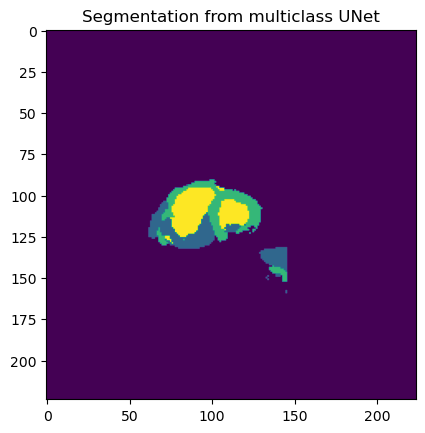

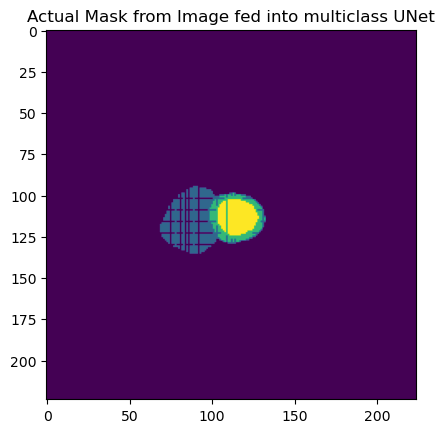

In [63]:

preds_cpu = preds.cpu()
masks_cpu= masks.cpu()

# Convert to NumPy array
preds_numpy = preds_cpu.numpy()
masks_numpy = masks_cpu.numpy()

plt.figure()
plt.imshow(preds_numpy[0,:,:])
plt.title('Segmentation from multiclass UNet')
plt.savefig('multiUNet_predictions.png')


plt.figure()
plt.imshow(masks_numpy[0,:,:])
plt.title('Actual Mask from Image fed into multiclass UNet')
plt.savefig('multiUNet_mask.png')


In [92]:
# TransUNet

model = TransUNet()

model.to(device) 

criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust learning rate as needed



# Training loop
num_epochs = 20  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    # j = 0;

    for images, masks in train_loader:
        # print(j)
        # j = j + 1
        images = images.to(device)
        masks = masks.to(device)
        images = images.float()  # Convert to FloatTensor
        masks = masks.float()     # Convert to FloatTensor
        # print(f"Images type: {images.dtype}, shape: {images.shape}")
        # print(f"Masks type: {masks.dtype}, shape: {masks.shape}")
        # print(images)
        
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # print(outputs.shape)
        # print(masks.shape)
        
        masks = torch.tensor(masks, dtype=torch.long)  # Correctly set as long
        
        # print("Labels dtype:", labels.dtype)  # Should be Long
        # print("Outputs dtype:", outputs.dtype)  # Should be Float
        # probabilities = F.softmax(outputs, dim=1)


        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    
    # Set the model to evaluation mode
    model.eval()
    
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            # masks = masks.float()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            masks = torch.tensor(masks, dtype=torch.long)  # Correctly set as long
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
    
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    

print('Training complete.')

Epoch [1/40], Loss: 0.8908
Validation Loss: 0.6608
Epoch [2/40], Loss: 0.3741
Validation Loss: 0.2429
Epoch [3/40], Loss: 0.2072
Validation Loss: 0.1919
Epoch [4/40], Loss: 0.1590
Validation Loss: 0.1492
Epoch [5/40], Loss: 0.1481
Validation Loss: 0.1402
Epoch [6/40], Loss: 0.1292
Validation Loss: 0.1336
Epoch [7/40], Loss: 0.1300
Validation Loss: 0.1278
Epoch [8/40], Loss: 0.1251
Validation Loss: 0.1290
Epoch [9/40], Loss: 0.1160
Validation Loss: 0.1137
Epoch [10/40], Loss: 0.1098
Validation Loss: 0.1194
Epoch [11/40], Loss: 0.1103
Validation Loss: 0.1175
Epoch [12/40], Loss: 0.1130
Validation Loss: 0.1095
Epoch [13/40], Loss: 0.1130
Validation Loss: 0.1257
Epoch [14/40], Loss: 0.1124
Validation Loss: 0.1092
Epoch [15/40], Loss: 0.0984
Validation Loss: 0.1039
Epoch [16/40], Loss: 0.0915
Validation Loss: 0.1080
Epoch [17/40], Loss: 0.0940
Validation Loss: 0.1057
Epoch [18/40], Loss: 0.0914
Validation Loss: 0.0861
Epoch [19/40], Loss: 0.0801
Validation Loss: 0.0857
Epoch [20/40], Loss: 

In [93]:
# Run test data and apply to measures

model.eval()

dice = []
# haus = []

with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            # masks = masks.float()
            masks = masks.long()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            # Apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)  # Apply softmax on the class dimension
        
            # Create predictions using argmax
            preds = torch.argmax(probs, dim=1)  # Get the predicted class indices
            
            batch_dice =multi_class_dice_coefficient(preds, masks, 4)
            
            # print(f'Batch Dice Score: {batch_dice:.4f}')  # Debugging line
                        
            dice.append(batch_dice)
            
            
 
# Stack tensors into one
dice = torch.stack(dice)  

# Calculate average Dice score
average_dice = dice.mean().item()  # Get the mean and convert to Python float
            
print(f'Average Dice Score is: {average_dice:.4f}')
print(f'Test Loss: {test_loss/len(test_loader):.4f}')




Average Dice Score is: 0.7435
Test Loss: 2.3440


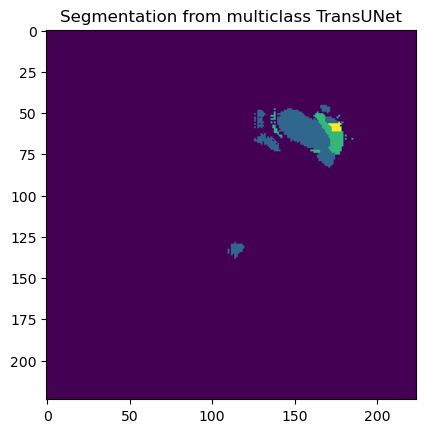

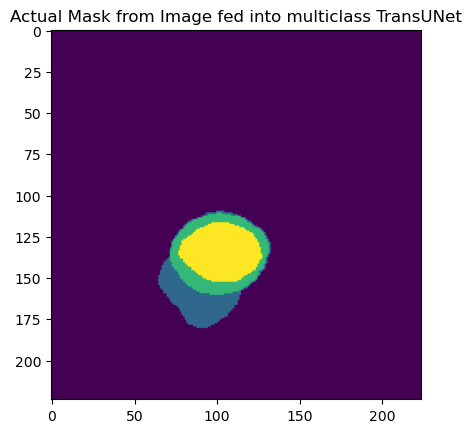

In [94]:
preds_cpu = preds.cpu()
masks_cpu= masks.cpu()

# Convert to NumPy array
preds_numpy = preds_cpu.numpy()
masks_numpy = masks_cpu.numpy()

plt.figure()
plt.imshow(preds_numpy[1,:,:])
plt.title('Segmentation from multiclass TransUNet')
plt.savefig('multiTransUNet_predictions.png')


plt.figure()
plt.imshow(masks_numpy[1,:,:])
plt.title('Actual Mask from Image fed into multiclass TransUNet')
plt.savefig('multiTransUNet_mask.png')

In [89]:
# ResU-Net


model = ResUNet()

model.to(device) 

criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust learning rate as needed



# Training loop
num_epochs = 20  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    # j = 0;

    for images, masks in train_loader:
        # print(j)
        # j = j + 1
        images = images.to(device)
        masks = masks.to(device)
        images = images.float()  # Convert to FloatTensor
        masks = masks.float()     # Convert to FloatTensor
        # print(f"Images type: {images.dtype}, shape: {images.shape}")
        # print(f"Masks type: {masks.dtype}, shape: {masks.shape}")
        # print(images)
        
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # print(outputs.shape)
        # print(masks.shape)
        
        masks = torch.tensor(masks, dtype=torch.long)  # Correctly set as long
        
        # print("Labels dtype:", labels.dtype)  # Should be Long
        # print("Outputs dtype:", outputs.dtype)  # Should be Float
        # probabilities = F.softmax(outputs, dim=1)


        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    
    # Set the model to evaluation mode
    model.eval()
    
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            # masks = masks.float()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            masks = torch.tensor(masks, dtype=torch.long)  # Correctly set as long
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
    
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    

print('Training complete.')

Epoch [1/40], Loss: 0.7337
Validation Loss: 0.6557
Epoch [2/40], Loss: 0.4372
Validation Loss: 0.4758
Epoch [3/40], Loss: 0.3977
Validation Loss: 0.3745
Epoch [4/40], Loss: 0.2720
Validation Loss: 0.2788
Epoch [5/40], Loss: 0.2095
Validation Loss: 0.2528
Epoch [6/40], Loss: 0.1879
Validation Loss: 0.1746
Epoch [7/40], Loss: 0.1329
Validation Loss: 0.1341
Epoch [8/40], Loss: 0.1036
Validation Loss: 0.1064
Epoch [9/40], Loss: 0.0994
Validation Loss: 0.1436
Epoch [10/40], Loss: 0.0988
Validation Loss: 0.1062
Epoch [11/40], Loss: 0.0826
Validation Loss: 0.1059
Epoch [12/40], Loss: 0.0806
Validation Loss: 0.1352
Epoch [13/40], Loss: 0.0766
Validation Loss: 0.1126
Epoch [14/40], Loss: 0.0648
Validation Loss: 0.0756
Epoch [15/40], Loss: 0.0632
Validation Loss: 0.0984
Epoch [16/40], Loss: 0.0619
Validation Loss: 0.1076
Epoch [17/40], Loss: 0.0512
Validation Loss: 0.0621
Epoch [18/40], Loss: 0.0495
Validation Loss: 0.0896
Epoch [19/40], Loss: 0.0548
Validation Loss: 0.1027
Epoch [20/40], Loss: 

In [90]:
model.eval()

dice = []
# haus = []

with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.float()  # Convert to FloatTensor
            # masks = masks.float()
            masks = masks.long()
            
            # print(images.shape)
            # print(masks.shape)

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            # Apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)  # Apply softmax on the class dimension
        
            # Create predictions using argmax
            preds = torch.argmax(probs, dim=1)  # Get the predicted class indices
            
            batch_dice =multi_class_dice_coefficient(preds, masks, 4)
            
            # print(f'Batch Dice Score: {batch_dice:.4f}')  # Debugging line
                        
            dice.append(batch_dice)
            
            
 
# Stack tensors into one
dice = torch.stack(dice)  

# Calculate average Dice score
average_dice = dice.mean().item()  # Get the mean and convert to Python float
            
print(f'Average Dice Score is: {average_dice:.4f}')
print(f'Test Loss: {test_loss/len(test_loader):.4f}')

Average Dice Score is: 0.8326
Test Loss: 2.2311


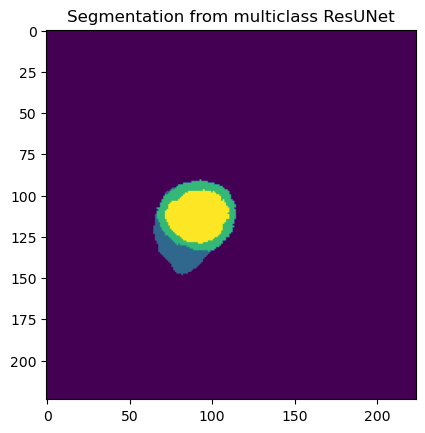

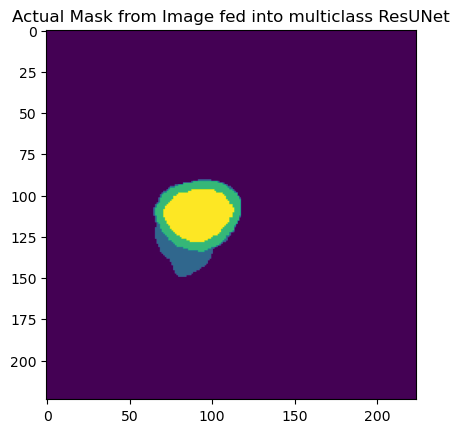

In [91]:
preds_cpu = preds.cpu()
masks_cpu= masks.cpu()

# Convert to NumPy array
preds_numpy = preds_cpu.numpy()
masks_numpy = masks_cpu.numpy()

plt.figure()
plt.imshow(preds_numpy[0,:,:])
plt.title('Segmentation from multiclass ResUNet')
plt.savefig('multiResUNet_predictions.png')


plt.figure()
plt.imshow(masks_numpy[0,:,:])
plt.title('Actual Mask from Image fed into multiclass ResUNet')
plt.savefig('multiResUNet_mask.png')

# Problem 4:

In [ ]:
# Load in the data

In [95]:
# nifti_file_path = '/blue/eel6935/guzikjar/Homeworks/Resources/training/patient044/patient044_frame01.nii.gz'
# nifti_mask_path = '/blue/eel6935/guzikjar/Homeworks/Resources/training/patient044/patient044_frame01_gt.nii.gz'
# img = sitk.ReadImage(nifti_file_path)
# msk = sitk.ReadImage(nifti_mask_path)

# # Convert to a numpy array
# data = sitk.GetArrayFromImage(img)
# labels = sitk.GetArrayFromImage(msk)


# for i in range(data.shape[0]):
#     plt.figure()
#     plt.imshow(data[i,:,:])
#     plt.figure()
#     plt.imshow(labels[i,:,:])

# # Print the shape of the data
# print(data.shape)

In [37]:
print(4)

4
